In [1]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import Word2Vec
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (4.0 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-manylinux2014_aarch64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-2.5.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata (21 kB)
  Using cached namex-0.0.8-py3-none-any.whl.metadata (246 bytes)
  Using cached op

In [3]:
pip install tensorflow scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [6]:
import pandas as pd
import re
import numpy as np

# Preprocessing the text

In [7]:
def load_data(file_path):
    texts, labels = [], []
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            sentence, emotion = line.strip().split(";")  # Split sentence from label
            texts.append(sentence)
            labels.append(emotion)
    return texts, labels

# Load train, validation, and test sets
train_texts, train_labels = load_data("/home/jovyan/Downloads/archive (2)/train.txt")
val_texts, val_labels = load_data("/home/jovyan/Downloads/archive (2)/val.txt")
test_texts, test_labels = load_data("/home/jovyan/Downloads/archive (2)/test.txt")

# Convert to Pandas DataFrame
df_train = pd.DataFrame({"text": train_texts, "label": train_labels})
df_val = pd.DataFrame({"text": val_texts, "label": val_labels})
df_test = pd.DataFrame({"text": test_texts, "label": test_labels})


In [8]:
df_test

,text,label
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


In [9]:
nltk.data.path = ["/home/jovyan/nltk_data", "/usr/local/nltk_data", "/usr/lib/nltk_data", "/usr/local/lib/nltk_data"]

# Ensure stopwords and tokenizer are downloaded
nltk.download("punkt", download_dir=nltk.data.path[0])
nltk.download("stopwords", download_dir=nltk.data.path[0])

try:
    stop_words = set(stopwords.words("english"))
except LookupError:
    stop_words = set()

# Initialize PorterStemmer
stemmer = PorterStemmer()

# Define a simple tokenization function using regex (avoids word_tokenize lookup issues)
def simple_tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())  # Extract words and convert to lowercase

# Define a preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters, punctuation, and extra spaces
    text = re.sub(r"[^a-z0-9\s]", "", text)
    
    # Tokenize using regex-based function (avoiding word_tokenize)
    tokens = simple_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    
    return " ".join(stemmed_tokens)  # Convert back to string

# Apply text preprocessing to each dataset
df_train["cleaned_text"] = df_train["text"].apply(preprocess_text)
df_val["cleaned_text"] = df_val["text"].apply(preprocess_text)
df_test["cleaned_text"] = df_test["text"].apply(preprocess_text)

# Display sample processed text
df_train.head()

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,label,cleaned_text
0,i didnt feel humiliated,sadness,didnt feel humili
1,i can go from feeling so hopeless to so damned...,sadness,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,anger,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,love,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,anger,feel grouchi


In [10]:
df_test

,text,label,cleaned_text
0,im feeling rather rotten so im not very ambiti...,sadness,im feel rather rotten im ambiti right
1,im updating my blog because i feel shitty,sadness,im updat blog feel shitti
2,i never make her separate from me because i do...,sadness,never make separ ever want feel like asham
3,i left with my bouquet of red and yellow tulip...,joy,left bouquet red yellow tulip arm feel slightl...
4,i was feeling a little vain when i did this one,sadness,feel littl vain one
...,...,...,...
1995,i just keep feeling like someone is being unki...,anger,keep feel like someon unkind wrong think get b...
1996,im feeling a little cranky negative after this...,anger,im feel littl cranki neg doctor appoint
1997,i feel that i am useful to my people and that ...,joy,feel use peopl give great feel achiev
1998,im feeling more comfortable with derby i feel ...,joy,im feel comfort derbi feel though start step s...


In [11]:
df_val

,text,label,cleaned_text
0,im feeling quite sad and sorry for myself but ...,sadness,im feel quit sad sorri ill snap soon
1,i feel like i am still looking at a blank canv...,sadness,feel like still look blank canva blank piec paper
2,i feel like a faithful servant,love,feel like faith servant
3,i am just feeling cranky and blue,anger,feel cranki blue
4,i can have for a treat or if i am feeling festive,joy,treat feel festiv
...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,im ssa examin tomorrow morn im quit well prepa...
1996,i constantly worry about their fight against n...,joy,constantli worri fight natur push limit inner ...
1997,i feel its important to share this info for th...,joy,feel import share info experi thing
1998,i truly feel that if you are passionate enough...,joy,truli feel passion enough someth stay true suc...


# EDA

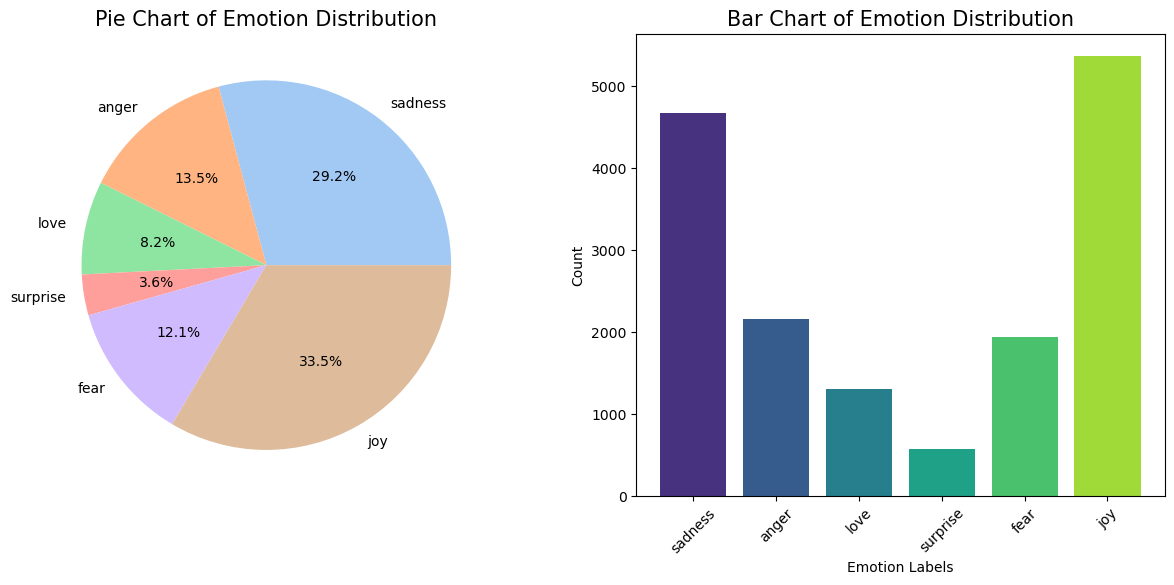

In [12]:
classes_dict = Counter(df_train["label"])

# Create subplots for visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Pie Chart for Class Distribution
ax[0].pie(classes_dict.values(), labels=classes_dict.keys(), autopct='%.1f%%', colors=sns.color_palette("pastel"))
ax[0].set_title("Pie Chart of Emotion Distribution", fontsize=15)

# Bar Chart for Class Distribution
ax[1].bar(classes_dict.keys(), classes_dict.values(), color=sns.color_palette("viridis", len(classes_dict)))
ax[1].set_title("Bar Chart of Emotion Distribution", fontsize=15)
ax[1].set_xlabel("Emotion Labels")
ax[1].set_ylabel("Count")
ax[1].tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

# Show plots
plt.show()

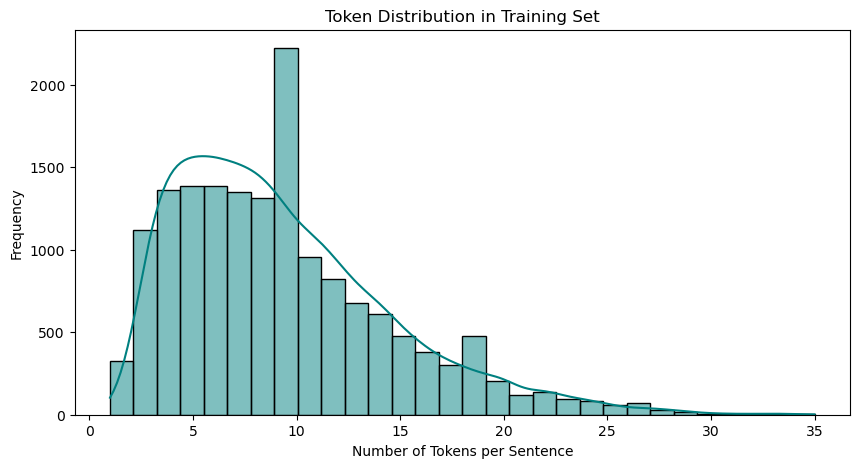

Average Sentence Length: 9.36 tokens


In [13]:
# Compute token count for each sentence
df_train["token_count"] = df_train["cleaned_text"].apply(lambda x: len(word_tokenize(x)))

# Plot Token Distribution (Sentence Length Analysis)
plt.figure(figsize=(10, 5))
sns.histplot(df_train["token_count"], bins=30, kde=True, color="teal")
plt.xlabel("Number of Tokens per Sentence")
plt.ylabel("Frequency")
plt.title("Token Distribution in Training Set")
plt.show()

# Compute and display the average sentence length
avg_sentence_length = df_train["token_count"].mean()
print(f"Average Sentence Length: {avg_sentence_length:.2f} tokens")

# Bag of Words

In [14]:
count_vectorizer = CountVectorizer(max_features=5000)  # Limit vocabulary size
X_train_bow = count_vectorizer.fit_transform(df_train["cleaned_text"])
X_val_bow = count_vectorizer.transform(df_val["cleaned_text"])
X_test_bow = count_vectorizer.transform(df_test["cleaned_text"])

In [15]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["label"])
y_val = label_encoder.transform(df_val["label"])
y_test = label_encoder.transform(df_test["label"])

# TF-IDF

In [16]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train["cleaned_text"])
X_val_tfidf = tfidf_vectorizer.transform(df_val["cleaned_text"])
X_test_tfidf = tfidf_vectorizer.transform(df_test["cleaned_text"])

# Word2vec  skip & CBOW

In [17]:
# Prepare training and test data
X_train, y_train = df_train["cleaned_text"], df_train["label"]
X_test, y_test = df_test["cleaned_text"], df_test["label"]
X_val, y_val = df_val["cleaned_text"], df_val["label"] 

# Tokenize sentences into words
tokenized_train = [sentence.split() for sentence in X_train]
tokenized_test = [sentence.split() for sentence in X_test]
tokenized_val = [sentence.split() for sentence in X_val]


# Function to convert sentences into averaged word vectors
def get_sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

In [18]:
# Train Word2Vec Models
w2v_cbow = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, sg=0)  # CBOW
# Convert text data to Word2Vec embeddings
X_train_w2v_cbow = np.array([get_sentence_vector(sent, w2v_cbow) for sent in X_train])
X_test_w2v_cbow = np.array([get_sentence_vector(sent, w2v_cbow) for sent in X_test])
X_val_w2v_cbow = np.array([get_sentence_vector(sent, w2v_cbow) for sent in X_val])

In [19]:
w2v_skipgram = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=2, sg=1)  # Skip-gram
X_train_w2v_skipgram = np.array([get_sentence_vector(sent, w2v_skipgram) for sent in X_train])
X_test_w2v_skipgram = np.array([get_sentence_vector(sent, w2v_skipgram) for sent in X_test])
X_val_w2v_skipgram = np.array([get_sentence_vector(sent, w2v_skipgram) for sent in X_val])

# Glove

In [20]:
# Load GloVe Embeddings
glove_path = "/home/jovyan/Downloads/glove.6B/glove.6B.100d.txt"  # Update this with your actual file path
glove_embeddings = {}

# Read GloVe file
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype=np.float32)
        glove_embeddings[word] = vector

print("Loaded {} word vectors from GloVe.".format(len(glove_embeddings)))

Loaded 400000 word vectors from GloVe.


In [21]:
# Function to convert text into averaged GloVe word vectors
def get_avg_glove_vector(text, embedding_dict, vector_size=100):
    words = word_tokenize(text)
    word_vectors = [embedding_dict[word] for word in words if word in embedding_dict]
    
    if len(word_vectors) == 0:
        return np.zeros(vector_size)  # Return zero vector if no words match
    
    return np.mean(word_vectors, axis=0)

# Convert train, validation, and test text into GloVe feature vectors
X_train_glove = np.array([get_avg_glove_vector(text, glove_embeddings) for text in df_train["cleaned_text"]])
X_val_glove = np.array([get_avg_glove_vector(text, glove_embeddings) for text in df_val["cleaned_text"]])
X_test_glove = np.array([get_avg_glove_vector(text, glove_embeddings) for text in df_test["cleaned_text"]])

# Summary

In [22]:
# Function to Train & Evaluate Logistic Regression
def train_and_evaluate(X_train, X_val, X_test, y_train, y_val, y_test, feature_name):
    print(f"\n🔹 Training Logistic Regression with {feature_name} Features 🔹")

    # Train Logistic Regression
    log_reg = LogisticRegression(max_iter=500)
    log_reg.fit(X_train, y_train)

    # Validation Accuracy
    val_preds = log_reg.predict(X_val)
    print(f"Validation Accuracy ({feature_name}):", accuracy_score(y_val, val_preds))
    print("Validation Report:\n", classification_report(y_val, val_preds, target_names=label_encoder.classes_))

    # Test Accuracy
    test_preds = log_reg.predict(X_test)
    print(f"Test Accuracy ({feature_name}):", accuracy_score(y_test, test_preds))
    print("Test Report:\n", classification_report(y_test, test_preds, target_names=label_encoder.classes_))

In [23]:
# Run Logistic Regression for Each Feature Set
train_and_evaluate(X_train_bow, X_val_bow, X_test_bow, y_train, y_val, y_test, "Bag-of-Words")
train_and_evaluate(X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train, y_val, y_test, "TF-IDF")
train_and_evaluate(X_train_glove, X_val_glove, X_test_glove, y_train, y_val, y_test, "Glove")
train_and_evaluate(X_train_w2v_cbow, X_val_w2v_cbow, X_test_w2v_cbow, y_train, y_val, y_test, "Word2Vec-CBOW")
train_and_evaluate(X_train_w2v_skipgram, X_val_w2v_skipgram, X_test_w2v_skipgram, y_train, y_val, y_test, "Word2Vec-skipgram")


🔹 Training Logistic Regression with Bag-of-Words Features 🔹
Validation Accuracy (Bag-of-Words): 0.854
Validation Report:
               precision    recall  f1-score   support

       anger       0.85      0.84      0.85       275
        fear       0.80      0.82      0.81       212
         joy       0.87      0.88      0.88       704
        love       0.78      0.70      0.74       178
     sadness       0.89      0.90      0.90       550
    surprise       0.73      0.75      0.74        81

    accuracy                           0.85      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.85      0.85      0.85      2000

Test Accuracy (Bag-of-Words): 0.8575
Test Report:
               precision    recall  f1-score   support

       anger       0.85      0.84      0.84       275
        fear       0.84      0.83      0.84       224
         joy       0.88      0.91      0.89       695
        love       0.73      0.67      0.70       159
     sadness

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/m

Validation Accuracy (Word2Vec-skipgram): 0.4205
Validation Report:
               precision    recall  f1-score   support

       anger       1.00      0.00      0.01       275
        fear       0.41      0.05      0.09       212
         joy       0.46      0.75      0.57       704
        love       0.43      0.02      0.03       178
     sadness       0.37      0.54      0.44       550
    surprise       0.00      0.00      0.00        81

    accuracy                           0.42      2000
   macro avg       0.44      0.23      0.19      2000
weighted avg       0.48      0.42      0.33      2000

Test Accuracy (Word2Vec-skipgram): 0.4375
Test Report:
               precision    recall  f1-score   support

       anger       1.00      0.00      0.01       275
        fear       0.21      0.01      0.03       224
         joy       0.46      0.78      0.58       695
        love       0.64      0.04      0.08       159
     sadness       0.40      0.55      0.47       581
    surp

/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/m

# LSTM

In [24]:
# Tokenization & Padding
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["cleaned_text"])
X_train_seq = tokenizer.texts_to_sequences(df_train["cleaned_text"])
X_val_seq = tokenizer.texts_to_sequences(df_val["cleaned_text"])
X_test_seq = tokenizer.texts_to_sequences(df_test["cleaned_text"])

# Padding sequences
max_length = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post")

In [25]:
embedding_dim = 100
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype=np.float32)
        if word in word_index:
            embedding_matrix[word_index[word]] = vector

In [26]:
# Build LSTM Model
model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dense(len(label_encoder.classes_), activation="softmax")
])

In [27]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["label"])
y_val = label_encoder.transform(df_val["label"])
y_test = label_encoder.transform(df_test["label"])

In [28]:
# Compile Model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train Model
model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=10, batch_size=32)

# Evaluate Model
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy (LSTM with GloVe): {acc:.4f}")

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.3168 - loss: 1.6215 - val_accuracy: 0.3520 - val_loss: 1.5834
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.3217 - loss: 1.5837 - val_accuracy: 0.3520 - val_loss: 1.5832
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.3385 - loss: 1.5805 - val_accuracy: 0.3525 - val_loss: 1.5838
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.3312 - loss: 1.5805 - val_accuracy: 0.3520 - val_loss: 1.5822
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.3275 - loss: 1.5791 - val_accuracy: 0.3520 - val_loss: 1.5807
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.3384 - loss: 1.5772 - val_accuracy: 0.3520 - val_loss: 1.5811
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - accuracy: 0.3387 - loss: 1.5710 - val_accuracy: 0.3520 - val_loss: 1.5810
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.3269 - loss: 1.5825 - 

In [29]:
y_pred_test = model.predict(X_test_pad)
y_pred_test = y_pred_test.argmax(axis=1)
test_f1_macro = f1_score(y_test, y_pred_test, average="macro")
print(f"LSTM with GloVe Test Macro F1-score: {test_f1_macro:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
LSTM with GloVe Test Macro F1-score: 0.0860


# LSTM - No Glove

In [30]:
list_txts = [x.split() for x in df_train["cleaned_text"]]
flattened_txts = [i for j in list_txts for i in j]
num_words = len(set(flattened_txts))

maxlen = max([len(x.split()) for x in df_train["cleaned_text"]])

In [31]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_train["cleaned_text"])

train_seqs = tokenizer.texts_to_sequences(df_train["cleaned_text"])
val_seqs = tokenizer.texts_to_sequences(df_val["cleaned_text"])
test_seqs = tokenizer.texts_to_sequences(df_test["cleaned_text"])

train_pad = pad_sequences(train_seqs,maxlen=maxlen)
val_pad = pad_sequences(val_seqs,maxlen=maxlen)
test_pad = pad_sequences(test_seqs,maxlen=maxlen)

In [32]:
model = Sequential([Embedding(input_dim=num_words,output_dim=100),
                  LSTM(64,input_shape=(maxlen,100)),
                  Dense(6,activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

/opt/conda/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [33]:
history = model.fit(train_pad,
                    y_train,
                    epochs=8,
                    validation_data=(val_pad, y_val),
                    shuffle=True,
                    batch_size=16)

Epoch 1/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.4450 - loss: 1.4052 - val_accuracy: 0.8235 - val_loss: 0.4964
Epoch 2/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8834 - loss: 0.3346 - val_accuracy: 0.8985 - val_loss: 0.2896
Epoch 3/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9278 - loss: 0.1954 - val_accuracy: 0.9125 - val_loss: 0.2520
Epoch 4/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9374 - loss: 0.1602 - val_accuracy: 0.9105 - val_loss: 0.2445
Epoch 5/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9500 - loss: 0.1296 - val_accuracy: 0.9115 - val_loss: 0.2434
Epoch 6/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9580 - loss: 0.1076 - val_accuracy: 0.9100 - val_loss: 0.2521
Epoch 7/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9669 - loss: 0.0904 - val_accuracy: 0.9065 - val_loss: 0.3025
Epoch 8/8
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9702 - loss: 0.0792 - val_accu

In [34]:
# Evaluate Model
loss, acc = model.evaluate(test_pad, y_test)
print(f"Test Accuracy (LSTM without GloVe): {acc:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8975 - loss: 0.3351
Test Accuracy (LSTM without GloVe): 0.8965


In [40]:
y_pred_test = model.predict(test_pad)
y_pred_test = y_pred_test.argmax(axis=1)  

test_f1_macro = f1_score(y_test, y_pred_test, average="macro")
print(f"LSTM without GloVe Test Macro F1-score: {test_f1_macro:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
LSTM without GloVe Test Macro F1-score: 0.8435


# CNN model

In [35]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define Tokenizer parameters
max_vocab_size = 5000  # Limit vocabulary size
max_length = 50  # Maximum length of sequences

# Initialize Tokenizer and fit on training data
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df_train["cleaned_text"])

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(df_train["cleaned_text"])
X_val_seq = tokenizer.texts_to_sequences(df_val["cleaned_text"])
X_test_seq = tokenizer.texts_to_sequences(df_test["cleaned_text"])

# Pad sequences to ensure uniform length
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding="post")
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding="post")

# Encode labels to numerical values
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train["label"])
y_val = label_encoder.transform(df_val["label"])
y_test = label_encoder.transform(df_test["label"])

# Convert labels to categorical format for multi-class classification
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes=len(label_encoder.classes_))
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=len(label_encoder.classes_))


In [36]:
# Define CNN Model for Text Classification
cnn_model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_length),
    Conv1D(filters=128, kernel_size=5, activation="relu"),  # Convolutional layer
    GlobalMaxPooling1D(),  # Max pooling to reduce sequence length
    Dense(64, activation="relu"),
    Dropout(0.5),  # Regularization to prevent overfitting
    Dense(len(label_encoder.classes_), activation="softmax")  # Output layer for multi-class classification
])

# Compile Model
cnn_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Display Model Summary
cnn_model.summary()

/opt/conda/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Define callbacks for training
early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_cnn_model.h5", save_best_only=True, monitor="val_accuracy", mode="max")

# Train the CNN model
cnn_model.fit(
    X_train_pad, y_train_cat,
    epochs=5,
    batch_size=32,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4825 - loss: 1.3228

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4829 - loss: 1.3220 - val_accuracy: 0.8990 - val_loss: 0.2854
Epoch 2/5
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9001 - loss: 0.2942

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9002 - loss: 0.2940 - val_accuracy: 0.9010 - val_loss: 0.2431
Epoch 3/5
497/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9367 - loss: 0.1715

500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9368 - loss: 0.1713 - val_accuracy: 0.9035 - val_loss: 0.2745
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9622 - loss: 0.1075 - val_accuracy: 0.8980 - val_loss: 0.3217
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9712 - loss: 0.0808 - val_accuracy: 0.9005 - val_loss: 0.3424


In [38]:
# Load Best Model
cnn_model.load_weights("best_cnn_model.h5")

# Predict on Test Set
y_pred_test_cnn = cnn_model.predict(X_test_pad)
y_pred_test_cnn = y_pred_test_cnn.argmax(axis=1)

# Compute Accuracy and F1-score
from sklearn.metrics import accuracy_score, f1_score

test_accuracy_cnn = accuracy_score(y_test, y_pred_test_cnn)
test_f1_macro_cnn = f1_score(y_test, y_pred_test_cnn, average="macro")

print(f"CNN Test Accuracy: {test_accuracy_cnn:.4f}, Test Macro F1-score: {test_f1_macro_cnn:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CNN Test Accuracy: 0.8925, Test Macro F1-score: 0.8478
